# BOSTON CONSULTING GROUP (BCG) - Explaining and Predicting Churn 
# Team N:
## Martina Cilia, Nadine Raad, Krishna Agrawal, Ignacio Gonzalez, Eric Von Stockar, George Moukheiber, Mikhael Dzhaneryan

## Predictive Analytics

In [1]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import timeit
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report,precision_score,\
f1_score,fbeta_score,precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError
from fast_ml.model_development import train_valid_test_split

In [2]:
# Importing the dataset and evluating data structure
df = pd.read_csv('clusteringtouse.csv', sep = ',')
df.head()

,client_id,recency,monetary,lifespan,clv,cluster_labels
0,1146680,0,11412,363,3450,loyal
1,1474013,0,90,0,30,potential_churner
2,816507,0,17730,363,4810,loyal
3,2051002,0,5149,132,600,potential_churner
4,224223,0,33042,361,6566,loyal


In [3]:
# Checking number of rows and columns
df.shape

(128285, 6)

In [4]:
# Checking data type for each column
df.dtypes

client_id          int64
recency            int64
monetary           int64
lifespan           int64
clv                int64
cluster_labels    object
dtype: object

In [5]:
# Resetting the index as client_id
df.set_index('client_id', inplace=True)
df.head(3)

,recency,monetary,lifespan,clv,cluster_labels
client_id,,,,,
1146680,0,11412,363,3450,loyal
1474013,0,90,0,30,potential_churner
816507,0,17730,363,4810,loyal


In [6]:
# Checking distribution of the cluster labels
df.cluster_labels.value_counts()

churned              55669
potential_churner    33956
new_customers        20912
loyal                17748
Name: cluster_labels, dtype: int64

In [7]:
# Calculating the percentage of each cluster label
churners = (round((55669) / (128285),2)*100)
potential_churners = (round((33956) / (128285),2)*100)
new_customers = (round((20912) / (128285),2)*100)
loyal_customers = (round((17748) / (128285),2)*100)

print(f'Churners: {churners}')
print(f'Potential Churners: {potential_churners}')
print(f'New Customers: {new_customers}')
print(f'Loyal Customers: {loyal_customers}')

Churners: 43.0
Potential Churners: 26.0
New Customers: 16.0
Loyal Customers: 14.000000000000002


In [8]:
# Brief statistical summary of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,128285.0,79.619745,94.144824,0.0,10.0,38.0,124.0,364.0
monetary,128285.0,5299.416385,7664.598769,-3203.0,513.0,1901.0,6556.0,37967.0
lifespan,128285.0,199.088413,136.355212,0.0,50.0,236.0,330.0,364.0
clv,128285.0,1180.445500,1579.049670,-330.0,177.0,518.0,1520.0,18725.0


In [9]:
# Defining functions to help us explore the dataset
def summarize_columns(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols

In [10]:
# Displaying the unique information for each column
summarize_columns(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
recency,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",304,0
monetary,"[11412, 90, 17730, 5149, 33042, 1290, 2051, 59...",24049,0
lifespan,"[363, 0, 132, 361, 222, 47, 75, 346, 341, 360,...",365,0
clv,"[3450, 30, 4810, 600, 6566, 245, 525, 880, 284...",4524,0
cluster_labels,"[loyal, potential_churner, churned, new_custom...",4,0


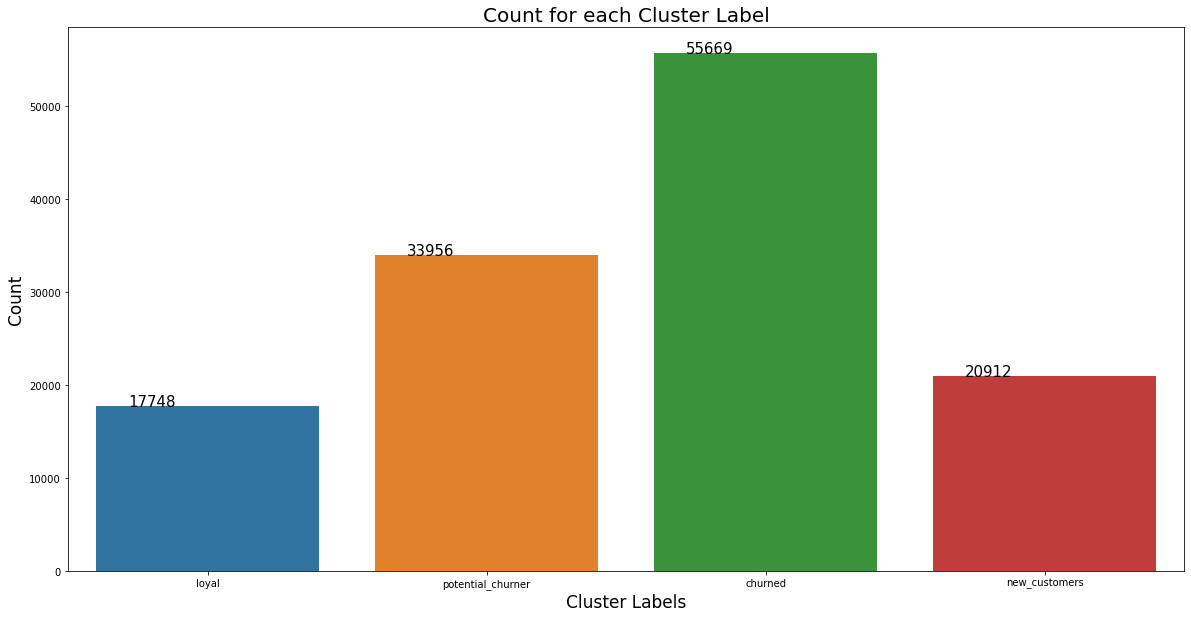

In [11]:
# Visual display of the distribution of the cluster labels
plt.figure(figsize = (20,10))
ax=sns.countplot(x = df['cluster_labels'], data = df)
ax.set_title("Count for each Cluster Label", fontsize = 20)
plt.xlabel("Cluster Labels",fontsize=17)
plt.ylabel("Count", fontsize=17)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=15, ha="center")

In [12]:
# Defining function to number cluster labels accordingly
def cluster_number(column):
    if column['cluster_labels'] == 'churned':
        return 1
    if column['cluster_labels'] == 'potential_churner':
        return 2
    if column['cluster_labels'] == 'new_customers':
        return 3
    if column['cluster_labels'] == 'loyal':
        return 4
    
df['cluster_number'] = df.apply (lambda column: cluster_number(column), axis=1)
df.head()

,recency,monetary,lifespan,clv,cluster_labels,cluster_number
client_id,,,,,,
1146680,0,11412,363,3450,loyal,4
1474013,0,90,0,30,potential_churner,2
816507,0,17730,363,4810,loyal,4
2051002,0,5149,132,600,potential_churner,2
224223,0,33042,361,6566,loyal,4


In [13]:
# Re-checking data shape to confirm no loss of data
df.shape

(128285, 6)

In [14]:
# Copying the dataset
dfc = df.copy()
dfc.head()

,recency,monetary,lifespan,clv,cluster_labels,cluster_number
client_id,,,,,,
1146680,0,11412,363,3450,loyal,4
1474013,0,90,0,30,potential_churner,2
816507,0,17730,363,4810,loyal,4
2051002,0,5149,132,600,potential_churner,2
224223,0,33042,361,6566,loyal,4


In [15]:
# Extracting the potential churners from the master dataset and creating a separate dataset that will be used to simulate
# real-life unseen data for customer churn predictions.

# We first have to change the data types into strings in order to be able to manipulate the columns as required
df['cluster_labels'] = df['cluster_labels'].astype(str)
# Locating and extracting all the information for potential churners
potential_churners = df.loc[(df['cluster_labels'] == 'potential_churner')]
# Saving and copying the extracted information into a new dataframe
topredict = potential_churners.copy()
# Dropping the cluster_labels & cluster_number column as we only need the dependent features for use later on upon 
# finalising our classifictaion model
topredict = topredict.drop(['cluster_labels','cluster_number'], axis=1)
topredict.head()

,recency,monetary,lifespan,clv
client_id,,,,
1474013,0,90,0,30
2051002,0,5149,132,600
816252,0,2051,47,525
224301,0,5962,75,880
1474574,0,2396,67,1064


In [16]:
# Dropping recency and cluster_labels from the master dataset. We will be using 1/Recency column and the cluster numbers instead.
df = df.drop(['cluster_labels'], axis=1)
df.head()

,recency,monetary,lifespan,clv,cluster_number
client_id,,,,,
1146680,0,11412,363,3450,4
1474013,0,90,0,30,2
816507,0,17730,363,4810,4
2051002,0,5149,132,600,2
224223,0,33042,361,6566,4


In [17]:
# Checking the count for each cluster number
df.cluster_number.value_counts()

1    55669
2    33956
3    20912
4    17748
Name: cluster_number, dtype: int64

In [18]:
# Only keeping information pertaining to cluster numbers 1,3,4 and excluding 2 since it represents the potential churners, the
# information of which we extracted and saved previously
df2 = df[df.cluster_number != 2]
df2.cluster_number.value_counts()

1    55669
3    20912
4    17748
Name: cluster_number, dtype: int64

In [19]:
# Defining a function that will create the our binary target churn variable {Churned: 1, Not churned: 0}
def churners(column):
    if column['cluster_number'] == 3:
        return 0
    if column['cluster_number'] == 4:
        return 0
    else:
        return 1 
    
df2['churned'] = df2.apply (lambda column: churners(column), axis=1)
df2.head()

,recency,monetary,lifespan,clv,cluster_number,churned
client_id,,,,,,
1146680,0,11412,363,3450,4,0
816507,0,17730,363,4810,4,0
224223,0,33042,361,6566,4,0
1474305,0,1290,222,245,1,1
2050789,0,6746,346,2844,1,1


In [20]:
# Dropping the cluster_number column since we do not need it anymore
df2 = df2.drop(['cluster_number'], axis=1)
df2.head()

,recency,monetary,lifespan,clv,churned
client_id,,,,,
1146680,0,11412,363,3450,0
816507,0,17730,363,4810,0
224223,0,33042,361,6566,0
1474305,0,1290,222,245,1
2050789,0,6746,346,2844,1


[Text(0, 0, '55669'), Text(0, 0, '38660')]

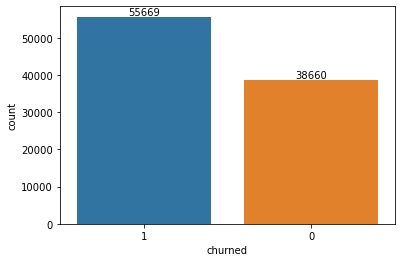

In [21]:
# Checking the count for each class for the target variable
ax = sns.countplot(x=df2['churned'],
                   order=df2['churned'].value_counts(ascending=False).index);
abs_values = df2['churned'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

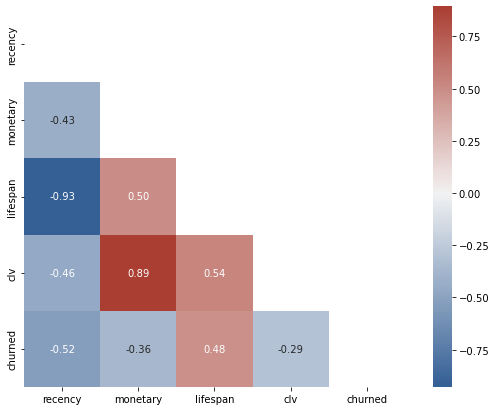

In [22]:
# Calculating pairwise-correlation between the features
matrix = df2.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(10, 7))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.show();

From the correlation matrix we can see that monetary and clv features are highly correlated. We need to avoid strong correlation between our dependent features since correlated features do not improve machine learning models. Thus, we will proceed with dropping the monetary variable. The reason being that customer lifetime value (clv) contains more significant and deterministic information to train our model for churn prediction. This monetary feature will also be dropped in our topredict dataset.

In [23]:
# Dropping the Monetary feature in the master and topredict dataset.
df2 = df2.drop(['monetary'], axis=1)
topredict = topredict.drop(['monetary'], axis=1)

In [24]:
df2.head()

,recency,lifespan,clv,churned
client_id,,,,
1146680,0,363,3450,0
816507,0,363,4810,0
224223,0,361,6566,0
1474305,0,222,245,1
2050789,0,346,2844,1


In [25]:
df2.shape

(94329, 4)

In [26]:
topredict.head()

,recency,lifespan,clv
client_id,,,
1474013,0,0,30
2051002,0,132,600
816252,0,47,525
224301,0,75,880
1474574,0,67,1064


In [27]:
topredict.shape

(33956, 3)

## Split the dataset into dependent and independent variables, and then perform numerical feature scaling.

In [28]:
# Separate the dataset into X and y values. 
# y wil be the ‘Churn’ column whilst x contains the remaining list of independent variables in the master dataset.
x = df2.iloc[:, :-1]
y = df2['churned']

In [29]:
x.shape

(94329, 3)

In [30]:
y.shape

(94329,)

In [31]:
# Generate training and test datasets by decoupling the master dataset into training and test set with an 80%-20% ratio.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)
list(map(lambda x: x.shape, [x_train, y_train, x_test, y_test]))

[(75463, 3), (75463,), (18866, 3), (18866,)]

In [32]:
# Scaling the numerical features so that all the training and test variables are scaled within a range of 0 to 1.
scaler = StandardScaler()

numerical_cols = ['recency','lifespan','clv']

x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = scaler.fit_transform(x_test[numerical_cols])

In [33]:
print(x_train.head())
print(x_train.shape)

            recency  lifespan       clv
client_id                              
2006474    2.690826 -1.939257 -0.809047
1871451   -0.762951  0.870470  0.126075
894623     0.480791 -0.153413 -0.011255
1662931    0.232043 -0.058168 -0.806719
1936186   -0.724682 -0.201036 -0.365053
(75463, 3)


In [34]:
print(y_train.head())
print(y_train.shape)

client_id
2006474    0
1871451    0
894623     1
1662931    1
1936186    1
Name: churned, dtype: int64
(75463,)


# Model Selection

Classification accuracy is one of the most common classification evaluation metrics to compare baseline algorithms as it is the number of correct predictions made as a ratio of total predictions. The following classification algorithms were modelled over the training dataset, with their respective evaluation metrics for the first iteration. These include:

1) Logistic Regression
2) SVM Linear
3) K-Nearest Neighbour
4) SVM RBF
5) Naive Bayes
6) Decision Tree
7) Random Forest
8) Bagging Classifier

In [35]:
y_train.value_counts()

1    44518
0    30945
Name: churned, dtype: int64

In [36]:
# Fitting Logistic Regression to the Training set
classifier_lr = LogisticRegression(random_state = 0)
classifier_lr.fit(x_train, y_train)
# Predicting the Test set results
y_pred = classifier_lr.predict(x_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
results = pd.DataFrame([['Logistic Regression', 
acc, prec, rec, f1, f2]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall', 'F1 Score', 
'F2 Score'])
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492


In [37]:
# Fitting SVM (SVC class) to the Training set
classifier_svm_linear = SVC(kernel = 'linear', random_state = 0)
classifier_svm_linear.fit(x_train, y_train)
# Predicting the Test set results y_pred = classifier.predict(X_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame(
[['SVM (Linear)', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision', 
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
1         SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492


In [38]:
# Fitting KNN to the Training set:
classifier_knn = KNeighborsClassifier(
n_neighbors = 22, 
metric = 'minkowski', p = 2)
classifier_knn.fit(x_train, y_train)
# Predicting the Test set results 
y_pred  = classifier_knn.predict(x_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['K-Nearest Neighbours', 
acc, prec, rec, f1, f2]], columns = ['Model',
 'Accuracy', 'Precision', 'Recall',
 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
2  K-Nearest Neighbours  0.942012   0.946620  0.955789  0.951183  0.953941
0   Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
1          SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492


In [39]:
# Fitting Kernel SVM to the Training set:
classifier_svm_rbf = SVC(kernel = 'rbf', random_state = 0)
classifier_svm_rbf.fit(x_train, y_train)
# Predicting the Test set results 
y_pred_svm = classifier_svm_rbf.predict(x_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([[
'SVM RBF', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision', 
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  K-Nearest Neighbours  0.942012   0.946620  0.955789  0.951183  0.953941
3               SVM RBF  0.942012   0.946620  0.955789  0.951183  0.953941
1   Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
2          SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492


In [40]:
# Fitting Naive Byes to the Training set:
classifier_gb = GaussianNB()
classifier_gb.fit(x_train, y_train)
# Predicting the Test set results 
y_pred = classifier_gb.predict(x_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([[
'Naive Byes', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision',
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  K-Nearest Neighbours  0.942012   0.946620  0.955789  0.951183  0.953941
1               SVM RBF  0.942012   0.946620  0.955789  0.951183  0.953941
2   Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
3          SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492
4            Naive Byes  0.908566   0.899069  0.952202  0.924873  0.941078


In [41]:
# Fitting Decision Tree to the Training set:
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(x_train, y_train)
# Predicting the Test set results 
y_pred_dt = classifier_dt.predict(x_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([[
'Decision Tree', acc, prec, rec, f1, f2]],
 columns = ['Model', 'Accuracy', 'Precision', 
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  K-Nearest Neighbours  0.942012   0.946620  0.955789  0.951183  0.953941
1               SVM RBF  0.942012   0.946620  0.955789  0.951183  0.953941
2   Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
3          SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492
4            Naive Byes  0.908566   0.899069  0.952202  0.924873  0.941078
5         Decision Tree  0.908566   0.899069  0.952202  0.924873  0.941078


In [42]:
# Fitting Random Forest to the Training set:
    
classifier_rf = RandomForestClassifier(n_estimators = 72,criterion = 'entropy', random_state = 0)
classifier_rf.fit(x_train, y_train)
# Predicting the Test set results 
y_pred = classifier_rf.predict(x_test)
#Evaluate results
from sklearn.metrics import confusion_matrix
accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Random Forest', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision','Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision","Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  K-Nearest Neighbours  0.942012   0.946620  0.955789  0.951183  0.953941
1               SVM RBF  0.942012   0.946620  0.955789  0.951183  0.953941
6         Random Forest  0.930934   0.935675  0.948345  0.941968  0.945784
2   Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
3          SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492
4            Naive Byes  0.908566   0.899069  0.952202  0.924873  0.941078
5         Decision Tree  0.908566   0.899069  0.952202  0.924873  0.941078


In [43]:
# Fitting Bagging Classifier to the Training set:
bagging_dtree = DecisionTreeClassifier(max_depth=3,
                                       criterion='entropy', random_state=0)
    
classifier_bag =  BaggingClassifier(base_estimator=bagging_dtree,
                                max_samples=10, n_estimators=10,
                                max_features=2, n_jobs=-1,
                                random_state=0)
classifier_bag.fit(x_train, y_train)
# Predicting the Test set results 
y_pred_bag = classifier_bag.predict(x_test)
#Evaluate results
from sklearn.metrics import confusion_matrix
accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Bagging Classifier', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision','Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision","Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  K-Nearest Neighbours  0.942012   0.946620  0.955789  0.951183  0.953941
1               SVM RBF  0.942012   0.946620  0.955789  0.951183  0.953941
2         Random Forest  0.930934   0.935675  0.948345  0.941968  0.945784
7    Bagging Classifier  0.930934   0.935675  0.948345  0.941968  0.945784
3   Logistic Regression  0.924785   0.926618  0.947807  0.937093  0.943492
4          SVM (Linear)  0.924785   0.926618  0.947807  0.937093  0.943492
5            Naive Byes  0.908566   0.899069  0.952202  0.924873  0.941078
6         Decision Tree  0.908566   0.899069  0.952202  0.924873  0.941078


In [44]:
results.head(8).sort_values(by='Accuracy',ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,K-Nearest Neighbours,0.942012,0.946620,0.955789,0.951183,0.953941
1,SVM RBF,0.942012,0.946620,0.955789,0.951183,0.953941
2,Random Forest,0.930934,0.935675,0.948345,0.941968,0.945784
7,Bagging Classifier,0.930934,0.935675,0.948345,0.941968,0.945784
3,Logistic Regression,0.924785,0.926618,0.947807,0.937093,0.943492
4,SVM (Linear),0.924785,0.926618,0.947807,0.937093,0.943492
5,Naive Byes,0.908566,0.899069,0.952202,0.924873,0.941078
6,Decision Tree,0.908566,0.899069,0.952202,0.924873,0.941078


From this first iteration, we concluded that the Decision Tree and Naive Bayes were the two baseline models that underperformed the most for this given dataset. This decision was based on two important evaluation metrics: accuracy and recall. Having a high accuracy is a good factor in determing how correct the classifier has been overall. Secondly, in this business case, having false negatives (i.e., falsely predicting that a customer will not churn) is detrimental to the profitability of the business. Thus, out of all the five-evaluation metrics, Recall was an important metric that helped narrow our choice from eight to six classification models that had the highest recall.

# K-fold Cross Validation

K-fold cross-validation method that primarily focuses on addressing the issue of variance. This occurs when the model shows good accuracy when run on the training and test set but shows different metrics when run on another test set. To address this, a K-fold of 10 was used. The training set was divided into ten folds, wherein nine were used as training before testing it on the final ‘test’ fold.

Thus, we proceeded with checking the accuracies with standard deviation for each classification algorithm as shown in the below code:

In [47]:
accuraciesrf = cross_val_score(estimator = classifier_rf,
X = x_train, y = y_train, cv = 10)

In [48]:
accuraciessvmrbf = cross_val_score(estimator = classifier_svm_rbf,
X = x_train, y = y_train, cv = 10)

In [49]:
accuraciesknn = cross_val_score(estimator = classifier_knn,
X = x_train, y = y_train, cv = 10)

In [50]:
accuraciesbag = cross_val_score(estimator = classifier_bag,
X = x_train, y = y_train, cv = 10)

In [51]:
accuracieslr = cross_val_score(estimator = classifier_lr,
X = x_train, y = y_train, cv = 10)

In [52]:
accuraciessvm = cross_val_score(estimator = classifier_svm_linear,
X = x_train, y = y_train, cv = 10)

In [53]:
print("Decision Tree with Bagging Classifier Accuracy: %0.2f (+/- %0.2f)" % (accuraciesbag.mean(),accuraciesbag.std() * 2))
print("Logistic Regression Classifier Accuracy: %0.2f (+/- %0.2f)" % (accuracieslr.mean(),accuracieslr.std() * 2))
print("SVM Linear Kernel Accuracy: %0.2f (+/- %0.2f)" % (accuraciessvm.mean(),accuraciessvm.std() * 2))
print("SVM RBF Kernel Accuracy: %0.2f (+/- %0.2f)" % (accuraciesdt.mean(),accuraciesdt.std() * 2))
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (accuraciessvm.mean(),accuraciessvm.std() * 2))
print("Random Forest: %0.2f (+/- %0.2f)" % (accuraciesrf.mean(),accuraciesrf.std() * 2))

Decision Tree with Bagging Classifier Accuracy: 0.93 (+/- 0.02)
Logistic Regression Classifier Accuracy: 0.93 (+/- 0.00)
SVM Linear Kernel Accuracy: 0.93 (+/- 0.00)
SVM RBF Kernel Accuracy: 0.92 (+/- 0.01)
KNN Accuracy: 0.93 (+/- 0.00)
Random Forest: 0.93 (+/- 0.01)


These results show us by how much i.e the range by which each classifier will vary in terms of accuracy.

# Training the chosen models on the training dataset and evaluating their results.

Unfortunately, we were not able to evaluate the Linear and RBF kernels for SVM due to computational power limitations.

These models were also re-evaluated using a Confusion Matrix and a Receiver Operating Characteristic (ROC) Graph. The Confusion Matrix was used to define the performance of each classification algorithm by visualising and summarising its performance. This also allowed a comparative evaluation between the classifiers. In addition, the ROC Graph is a good graphical representation of the capability of each model to distinguish between churn and no-churn based on the AUC Mean Score. The orange line represents the ROC of any randomly chosen classifier. A very good classifier will push upwards and away from it as much as possible, whereas a bad one will push downwards and away from it meaning that its performance is worse than any random classifier. 


## Decision Tree Confusion Matrix & ROC

In [54]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.20, random_state=0,shuffle=True)
x_train_dt, x_test_dt, y_train_dt, y_test_dt = data_splits

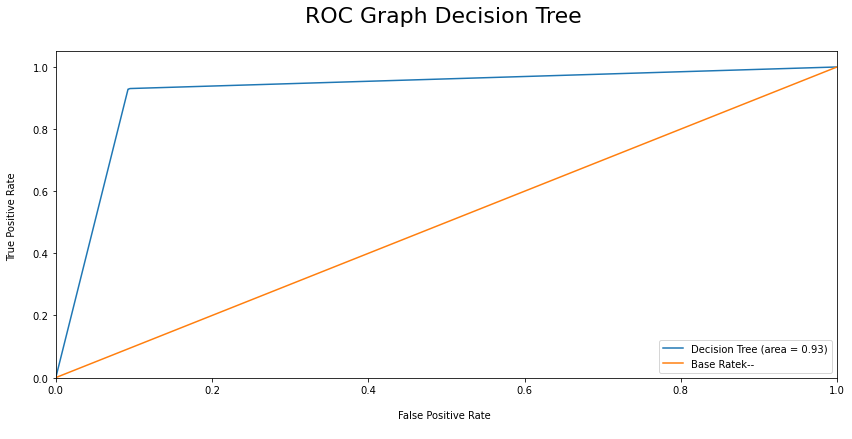

In [55]:
classifier_dt.fit(x_train_dt, y_train_dt) 
probs = classifier_dt.predict_proba(x_test_dt) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test_dt, y_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test_dt, classifier_dt.predict_proba(x_test_dt)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Decision Tree (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph Decision Tree \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Text(0.5, 16.0, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

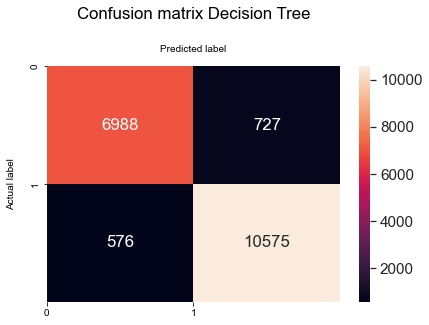

In [56]:
cm = confusion_matrix(y_test_dt, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix Decision Tree\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

## K-Nearest Neighbour Confusion Matrix & ROC

In [57]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.20, random_state=0,shuffle=True)
x_train_knn, x_test_knn, y_train_knn, y_test_knn = data_splits

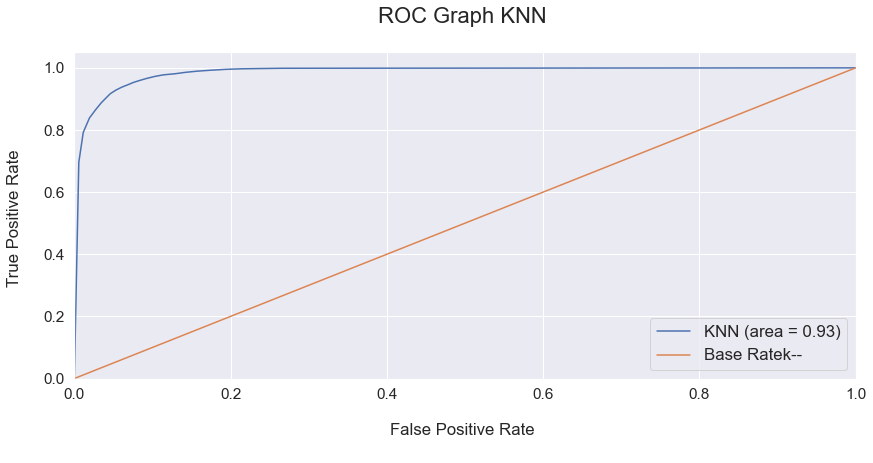

In [58]:
classifier_knn.fit(x_train_knn, y_train_knn) 
probs = classifier_knn.predict_proba(x_test_knn) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test_knn, y_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test_knn, classifier_knn.predict_proba(x_test_knn)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='KNN (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph KNN \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Text(0.5, 8.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

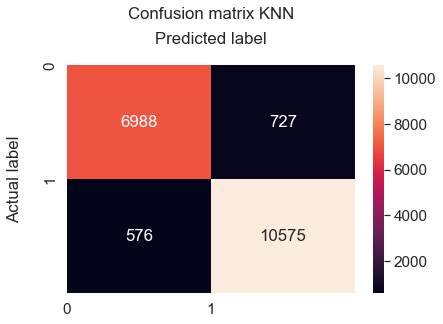

In [59]:
cm = confusion_matrix(y_test_knn, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix KNN\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

## Logistic Regression Confusion Matrix & ROC

In [60]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.20, random_state=0,shuffle=True)
x_train_lr, x_test_lr, y_train_lr, y_test_lr = data_splits

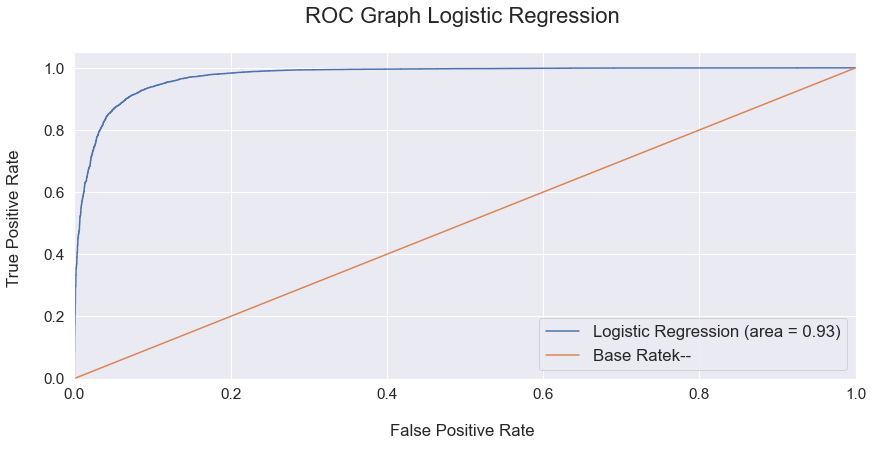

In [61]:
classifier_lr.fit(x_train_lr, y_train_lr) 
probs = classifier_lr.predict_proba(x_test_lr) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test_lr, y_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test_lr, classifier_lr.predict_proba(x_test_lr)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Logistic Regression (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph Logistic Regression \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Text(0.5, 8.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

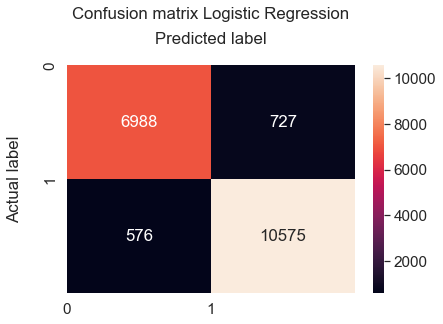

In [62]:
cm = confusion_matrix(y_test_lr, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [63]:
# Analyzing Coefficients
feature_importances = pd.concat([
pd.DataFrame(x_train_lr.
columns, columns = ["features"]),
pd.DataFrame(np.transpose(classifier_lr.coef_), 
columns = ["coef"])],axis = 1)
feature_importances.sort_values("coef", ascending = False)

,features,coef
1,lifespan,0.022526
2,clv,-0.002535
0,recency,-0.014923


Logistic Regression has the internal capability of determining the key features that have the most significance in predicting the target, which in this case is ‘Churn’.

## Bagging Classifier Confusion Matrix & ROC

In [64]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.20, random_state=0,shuffle=True)
x_train_bag, x_test_bag, y_train_bag, y_test_bag = data_splits

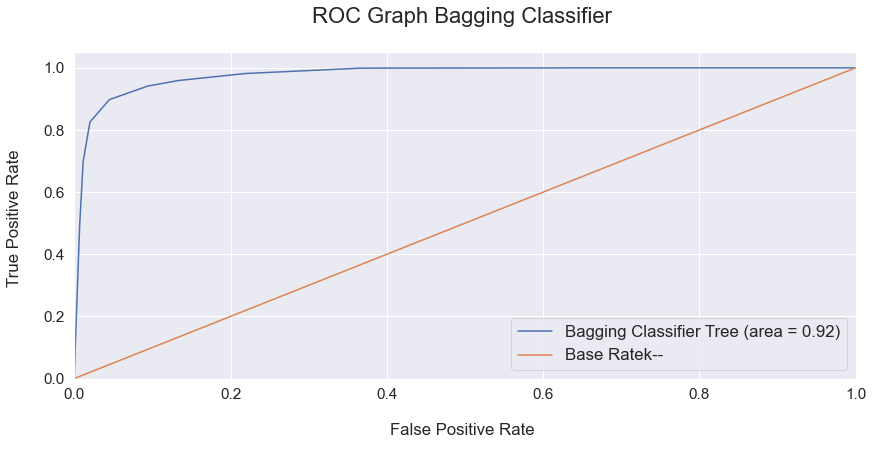

In [65]:
classifier_bag.fit(x_train_bag, y_train_bag) 
probs = classifier_bag.predict_proba(x_test_bag) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test_bag, y_pred_bag)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test_bag
                                          , classifier_bag.predict_proba(x_test_bag)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Bagging Classifier Tree (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph Bagging Classifier \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Text(0.5, 8.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

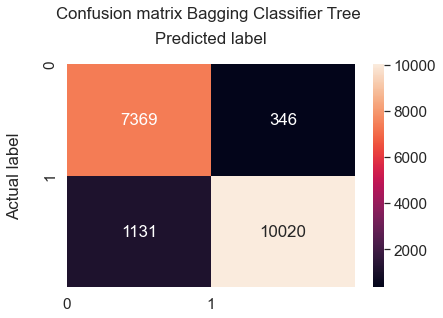

In [66]:
cm = confusion_matrix(y_test_bag, y_pred_bag) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix Bagging Classifier Tree \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

We decided to proceed with the Logistic Regression Classifier and the Bagging Classifier. Logistic Regression is well known to be one of the most effective algorithms for XOR problems. We proceeded with Bagging Classifier too since it was the only algorithm that showed different values for the confusion matrix. We wanted to check whether these could be improved with hyperparameter tuning

# Hyperparameter Tuning Logistic Regression & Decision Tree Bagging Classifier

The next step was to improve the models by choosing the best hyperparameters. These configurable values that are external to the model that is not determined by the data are given and were optimized through a common parameter tuning technique called Grid Search. This was done for Logistic Regression and Bagging Classifier.

## Logistic Regression Classifier

For Logistic Regression we determined whether L1 or L2 Regularisation best suited the model for this dataset.

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.20, random_state=0,shuffle=True)
x_train_lr, x_test_lr, y_train_lr, y_test_lr = data_splits


# Round 1:
 
# Select Regularization Method   
import time
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Combine Parameters
parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier_lr,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
lr_classifier  = lr_classifier.fit(x_train_lr, y_train_lr)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

Took 6.18 seconds


(0.919546409388785, {'C': 0.001, 'penalty': 'l2'})

In [68]:
# Round 2:
# Select Regularization Method
import time
penalty = ['l2']
# Create regularization hyperparameter space
C = [ 0.0001, 0.001, 0.01, 0.02, 0.05]
# Combine Parameters
parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier_lr,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
lr_classifier  = lr_classifier .fit(x_train_lr, y_train_lr)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

Took 3.36 seconds


(0.919546409388785, {'C': 0.0001, 'penalty': 'l2'})

In [69]:
from sklearn.linear_model import LogisticRegressionCV
lr_classifier = LogisticRegressionCV(cv=10, max_iter=1000,
                                scoring='f1', penalty='l2', solver='liblinear',
                                n_jobs=-1, random_state=0, refit=True, verbose=0)
lr_classifier.fit(x_train_lr, y_train_lr)
# Predict the Test set results
y_pred_lr = lr_classifier.predict(x_test_lr)
#probability score
y_pred_probs_lr = lr_classifier.predict_proba(x_test_lr)
y_pred_probs_lr  = y_pred_probs_lr [:, 1]

[[ 6878   837]
 [  603 10548]]
Test Data Accuracy: 0.9309


<Figure size 2016x1440 with 0 Axes>

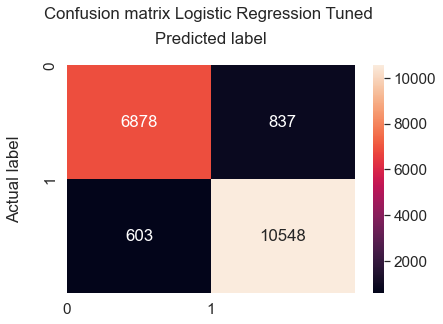

In [70]:
#Revalidate final results with Confusion Matrix:
cm = confusion_matrix(y_test_lr, y_pred_lr) 
print (cm)
#Confusion Matrix as a quick Crosstab:
    
pd.crosstab(y_test_lr,pd.Series(y_pred_lr),
rownames=['ACTUAL'],colnames=['PRED'])
#visualize Confusion Matrix:
cm = confusion_matrix(y_test_lr, y_pred_lr) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression Tuned \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

## Decision Tree with Bagging Classifier

For the Decision Tree with Bagging Classifier, we proceeded to check which were the best hyperparameters for both the Decision Tree Classifier and the Bagging Classifier algorithms using Grid Search. 

In [71]:
from sklearn.model_selection import GridSearchCV
#Creating a GridSearchCV object:

parameters = {'max_depth':[15,20,25,30], 'max_features':[1,2,3]}
forest = DecisionTreeClassifier()
clf = GridSearchCV(estimator=forest, param_grid=parameters, n_jobs=-1, cv=5)

In [72]:
clf.fit(x, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25, 30],
                         'max_features': [1, 2, 3]})

In [73]:
# Checking the best parameters and overall accuracy:
clf.best_params_

{'max_depth': 15, 'max_features': 3}

In [74]:
bagparameters = {'n_estimators':[150,200,250,300],'max_samples':[20,40,60,80], 'max_features':[1,2,3]}
bagforest = BaggingClassifier()
bagclf = GridSearchCV(estimator=bagforest, param_grid=bagparameters, n_jobs=-1, cv=5)

In [75]:
bagclf.fit(x, y)

GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [1, 2, 3],
                         'max_samples': [20, 40, 60, 80],
                         'n_estimators': [150, 200, 250, 300]})

In [76]:
# Checking the best parameters and overall accuracy:
bagclf.best_params_

{'max_features': 3, 'max_samples': 40, 'n_estimators': 200}

In [77]:
bagging_dtree = DecisionTreeClassifier(max_depth=20,
                                       criterion='entropy', random_state=0)

bagging_classifier = BaggingClassifier(base_estimator=bagging_dtree,
                                max_samples=40, n_estimators=300,
                                max_features=3, n_jobs=-1,
                                random_state=0)

In [78]:
bagging_classifier.fit(x_train_bag, y_train_bag)
# Predict the Test set results
y_pred_bag_improved = bagging_classifier.predict(x_test_bag)
#probability score
y_pred_probs_bag_improved = bagging_classifier.predict_proba(x_test_bag)
y_pred_probs_bag_improved  = y_pred_probs_bag_improved [:, 1]

[[ 7369   346]
 [ 1131 10020]]
Test Data Accuracy: 0.9217


<Figure size 2016x1440 with 0 Axes>

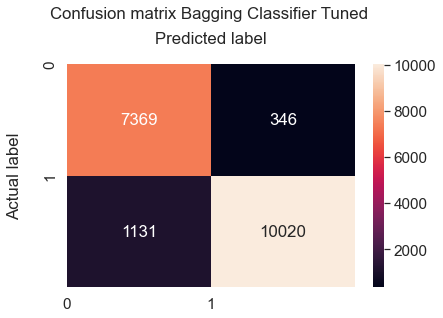

In [79]:
#Revalidate final results with Confusion Matrix:
cm = confusion_matrix(y_test_bag, y_pred_bag) 
print (cm)
#Confusion Matrix as a quick Crosstab:
    
pd.crosstab(y_test_bag,pd.Series(y_pred_bag),
rownames=['ACTUAL'],colnames=['PRED'])
#visualize Confusion Matrix:
cm = confusion_matrix(y_test_bag, y_pred_bag) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix Bagging Classifier Tuned \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test_bag, y_pred_bag))

However, upon upgrading these configurable values for the ensemble Bagging Classifier model, no improvement was noted as evidenced by its correlation matrices before and after hyperparameter tuning.

Conclusively, the accuracy and error rate for the Bagging Classifier remained the same following hyper-parameter tuning. In contrast, for the tuned Logistic Regression Classifier, the accuracy rate decreased by 0.72 % and the error rate increased by 0.73 % This may not seem much but when dealing with thousands of clients it amounts to a lot.

# Saving the final model

Based on the results so far, the baseline Logistic Regression classifier has been chosen as our final model. Even though hyperparameter tuning did not improve the model, but rather decreased the accuracy score (and increased the error rate) when compared to the original one, it still has better evaluation metrics compared to the untuned and tuned Bagging Classifier.

In [80]:
# Saving the final classifier model
import joblib as joblib
joblib.dump(lr_classifier, 'final_model_lr.pkl.pkl')

['final_model_lr.pkl.pkl']

# Propensity to Churn

Beyond the technical aspect of building a predictive model, the business side of the churn problem that is being addressed requires that the unpredictability and risk modelled by the model be further translated into a business metric. One that can be used and exploited by the company’s executives and managers to continue to drive profitability through a customer-centric approach. In reality, such customer churn prediction models, besides the predicated binary outcome, are accompanied by a propensity score. Thus, to keep on threading the business aim of this project, we proceeded to create a propensity score for each customer. This score highlights each customer’s individual percentage probability of churning, with some having a higher probability than others. Hence, this gives the company the ability to prioritise its communication and commercial activity in the following weeks to maximise the number of product sales by targeting the higher at-risk customers. 

In [85]:
# Calculating propensity to churn
final_results = pd.concat([x_test_lr, y_test_lr], axis = 1).dropna()
final_results['predictions'] = y_pred_lr
final_results["propensity_to_churn(%)"] = y_pred_probs_lr
final_results["propensity_to_churn(%)"] = final_results["propensity_to_churn(%)"]*100
final_results["propensity_to_churn(%)"]=final_results["propensity_to_churn(%)"].round(2)
final_results = final_results[['churned', 'predictions', 'propensity_to_churn(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_churn(%)'].rank(method = 'first'),10,labels=range(10,0,-1))
final_results.head(10).sort_values(by='propensity_to_churn(%)',ascending=False)

,churned,predictions,propensity_to_churn(%),Ranking
client_id,,,,
945282,1,1,99.60,1
868041,1,1,98.95,2
2045730,1,1,94.99,4
1851321,1,1,60.47,6
497819,0,0,4.65,8
1232059,0,0,4.26,8
729959,0,0,1.37,9
1606032,0,0,0.06,10
329064,0,0,0.00,10


In [83]:
final_results.shape

(18866, 3)

[Text(0, 0, '11385'), Text(0, 0, '7481')]

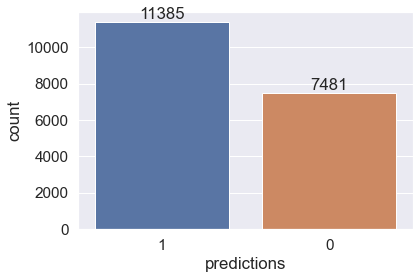

In [84]:
# Checking distribution of predicted churners in our X-test
ax = sns.countplot(x=final_results['predictions'],
                   order=final_results['predictions'].value_counts(ascending=False).index);
abs_values = final_results['predictions'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

# Predicting the identified Potential to Churn customers (medium to low value customer segment) using the final model.

In [86]:
# Predicting on our potential to churn customers
pred = lr_classifier.predict(topredict)

In [87]:
# Checking that there are the same amount of predictions as there are rows in the topredict dataframe
pred.shape

(33956,)

In [88]:
# Checking shape of dataset - confirming that there are correct number of predictions as shown above.
topredict.shape

(33956, 3)

In [89]:
# Resetting the index so that client id is no longer an index but a column
topredict.reset_index(inplace=True)

In [90]:
topredict.head()

,client_id,recency,lifespan,clv
0,1474013,0,0,30
1,2051002,0,132,600
2,816252,0,47,525
3,224301,0,75,880
4,1474574,0,67,1064


In [91]:
# Putting the predicted results in a list
y_pred_logistic_regression = []
for prediction in pred:
    if prediction >0.5:
        y_pred_logistic_regression.append(1)
    else:
        y_pred_logistic_regression.append(0)

In [92]:
# Printing the predicted values
print(y_pred_logistic_regression[:20]) 

[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


In [93]:
# Converting array into a dataframe to be able to concatenate with the independent variables
data_pred = y_pred_logistic_regression
results = pd.DataFrame(data=data_pred)

In [94]:
# Concatenating the predictions with the independent variables
potential_churners_predicted = pd.concat([topredict,results],axis=1)

In [95]:
# Changing the prediction column name from 0 to 'prediction' for ease of reference
potential_churners_predicted = potential_churners_predicted.rename(columns = { 0: 'prediction'})

In [96]:
# Removing the the rest of the features and keeping the client_id and predictions only
potential_churners_predictions = potential_churners_predicted.drop(['recency','lifespan','clv'], axis = 1)
potential_churners_predictions.head()

,client_id,prediction
0,1474013,0
1,2051002,1
2,816252,0
3,224301,0
4,1474574,0


[Text(0, 0, '21085'), Text(0, 0, '12871')]

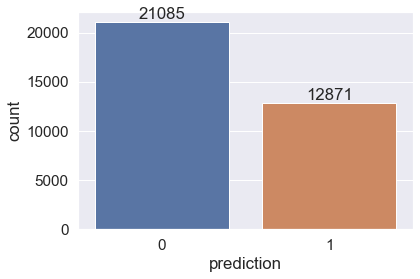

In [97]:
# Checking distribution of our predictions for our potential churners cluster
ax = sns.countplot(x=potential_churners_predictions['prediction'],
                   order=potential_churners_predictions['prediction'].value_counts(ascending=False).index);
abs_values = potential_churners_predictions['prediction'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

In [98]:
#Saving the dataframe as a csv file
potential_churners_predictions.to_csv(r'C:\Users\cilia\potential_churners_predictions.csv', index=False)